In [3]:
import os
import random

from PIL import Image, ImageDraw, ImageFont

In [2]:
data_dir = r"F:\OneDrive\toShare\Gabrilyi\leaflet_project\labeled\1_Gabriel_10102024"
SCALE = 0.3

In [30]:
all_images = os.listdir(os.path.join(data_dir, "images"))
all_labels = os.listdir(os.path.join(data_dir, "labels"))

rnd_index = random.randint(0, len(all_images) - 1)
rnd_img = all_images[rnd_index]
rnd_label = all_labels[rnd_index]

print(rnd_img)
print(rnd_label)

rnd_img = Image.open(os.path.join(data_dir, "images", rnd_img))
image_width, image_height = rnd_img.size

with open(os.path.join(data_dir, "labels", rnd_label), "r") as f:
    lines = f.readlines()
    lines = [line.strip().replace("\n", "").split(" ") for line in lines]

for line in lines:
    class_name = line[0]
    points = [float(point) for point in line[1:]]
    points = [(points[i], points[i + 1]) for i in range(0, len(points), 2)]
    points = [(int(point[0] * image_width), int(point[1] * image_height)) for point in points]

    draw = ImageDraw.Draw(rnd_img)
    draw.polygon(points, outline="red", width=10)
    font = ImageFont.load_default()
    draw.text(points[0], class_name, font=font, fill="red")

rnd_img.show()

20389b7b-aldi-sud_2407534_3.jpg
20389b7b-aldi-sud_2407534_3.txt


In [14]:
from dotenv import load_dotenv
import os
from PIL import Image
import pandas as pd
from ultralytics import YOLO
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image, ImageDraw

load_dotenv()

PROJECT_DIR = os.getenv("PROJECT_DIR")
DEAL_ANNOTATION_PATH = os.path.join(PROJECT_DIR, "labeled_deals_gabriel.csv")
LEAFLET_DIR = os.path.join(PROJECT_DIR, "crawled_leaflets")
DABASE_PATH = os.path.join(LEAFLET_DIR, "supermarket_leaflets.db")
DEALS_DIR = os.path.join(PROJECT_DIR, "deals")
MODELS_DIR = os.path.join(PROJECT_DIR, "models")
YOLO_MODEL_PATH = os.path.join(MODELS_DIR, "model.pt")
YOLO_MODEL = YOLO(YOLO_MODEL_PATH, verbose=False)

ALL_IMAGES = []
# os.walk
for dirpath, dirnames, filenames in os.walk(LEAFLET_DIR):
    for filename in filenames:
        if filename.endswith(".jpg") or filename.endswith(".png"):
            ALL_IMAGES.append(os.path.join(dirpath, filename))

print(f"Found {len(ALL_IMAGES)} images in {DEALS_DIR}")

Found 13452 images in F:\OneDrive\toShare\Gabrilyi\leaflet_project\deals


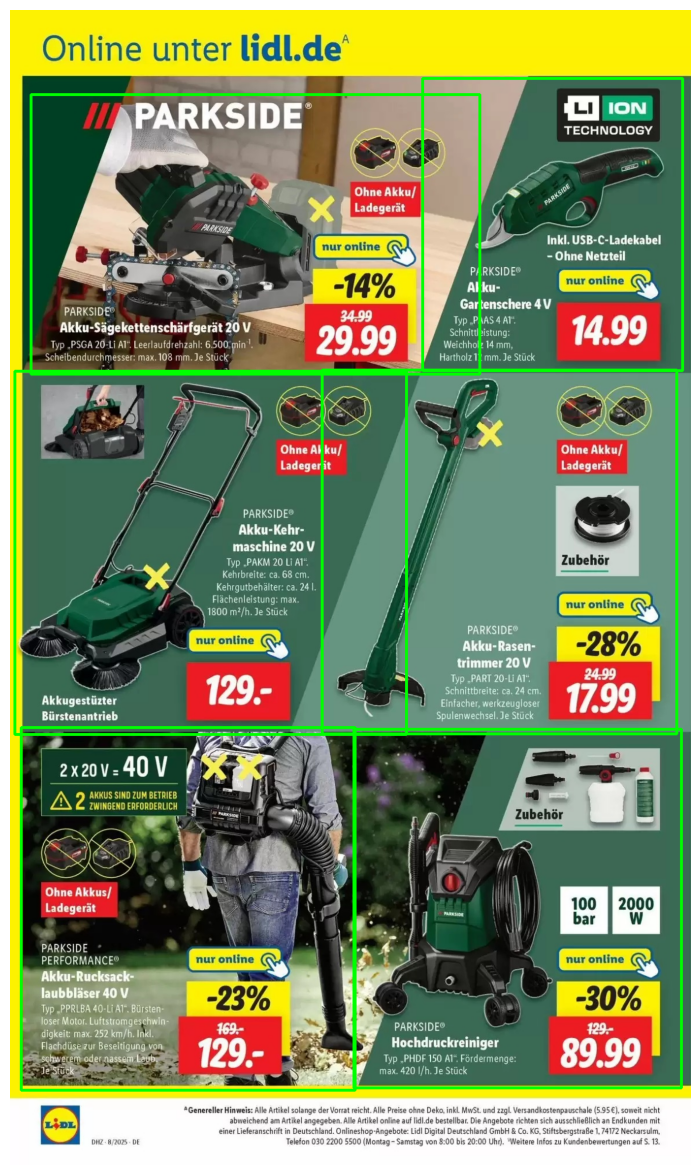

In [74]:
# Select a random image
# random_image_path = random.choice(ALL_IMAGES)
random_image_path = r"F:\OneDrive\toShare\Gabrilyi\leaflet_project\crawled_leaflets\lidl\2726046\lidl_2726046_4.jpg"
image = Image.open(random_image_path).convert("RGB")

# Run inference
results = YOLO_MODEL(random_image_path,
            iou=0.4,
            conf=0.6,
            # half=True,
            device="cuda:0",
            verbose=False
        )

output_dir = "inference_output"
os.makedirs(output_dir, exist_ok=True)
# cp original image to output dir
image.save(os.path.join(output_dir, "original.png"))

# Convert PIL Image to OpenCV format
image_cv_bbox = np.array(image)
image_cv_mask = image_cv_bbox.copy()

# Draw bounding boxes on a copy of the original image
for result in results:
    for i, box in enumerate(result.boxes.xyxy):
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(image_cv_bbox, (x1, y1), (x2, y2), (0, 255, 0), 4)

        # save individual bbox image
        bbox_image = np.array(image)[y1:y2, x1:x2]
        cv2.imwrite(os.path.join(output_dir, f"bbox_{i}.png"), cv2.cvtColor(bbox_image, cv2.COLOR_RGB2BGR))

# Draw masks on another copy of the original image
for result in results:
    if result.masks:
        for i, mask in enumerate(result.masks.xy):
            mask = np.array(mask, np.int32)
            # cv2.polylines(image_cv_mask, [mask], isClosed=True, color=(0, 0, 255), thickness=4)

            # Create a mask for the polygon
            mask_img = np.zeros(image_cv_mask.shape[:2], dtype=np.uint8)
            cv2.fillPoly(mask_img, [mask], 255)

            # Extract the polygon region
            polygon_region = cv2.bitwise_and(image_cv_mask, image_cv_mask, mask=mask_img)

            # Find bounding box of the polygon
            x_coords = mask[:, 0]
            y_coords = mask[:, 1]
            x_min, x_max = min(x_coords), max(x_coords)
            y_min, y_max = min(y_coords), max(y_coords)

            # Create transparent cutout
            cutout = np.zeros((y_max - y_min + 1, x_max - x_min + 1, 4), dtype=np.uint8)
            cutout[:, :, :3] = polygon_region[y_min : y_max + 1, x_min : x_max + 1]
            cutout[:, :, 3] = mask_img[y_min : y_max + 1, x_min : x_max + 1]

            # Convert cutout to PIL Image with transparency
            cutout_pil = Image.fromarray(cutout, "RGBA")
            cutout_pil.save(os.path.join(output_dir, f"mask_cutout_{i}.png"))

# save images
cv2.imwrite(os.path.join(output_dir, "bbox.png"), cv2.cvtColor(image_cv_bbox, cv2.COLOR_RGB2BGR))
cv2.imwrite(os.path.join(output_dir, "mask.png"), cv2.cvtColor(image_cv_mask, cv2.COLOR_RGB2BGR))

# Show results in two different images (no subplot)
plt.figure(figsize=(25, 15))
plt.imshow(image_cv_bbox)
plt.axis('off')
# plt.title('Bounding Boxes')
plt.show()


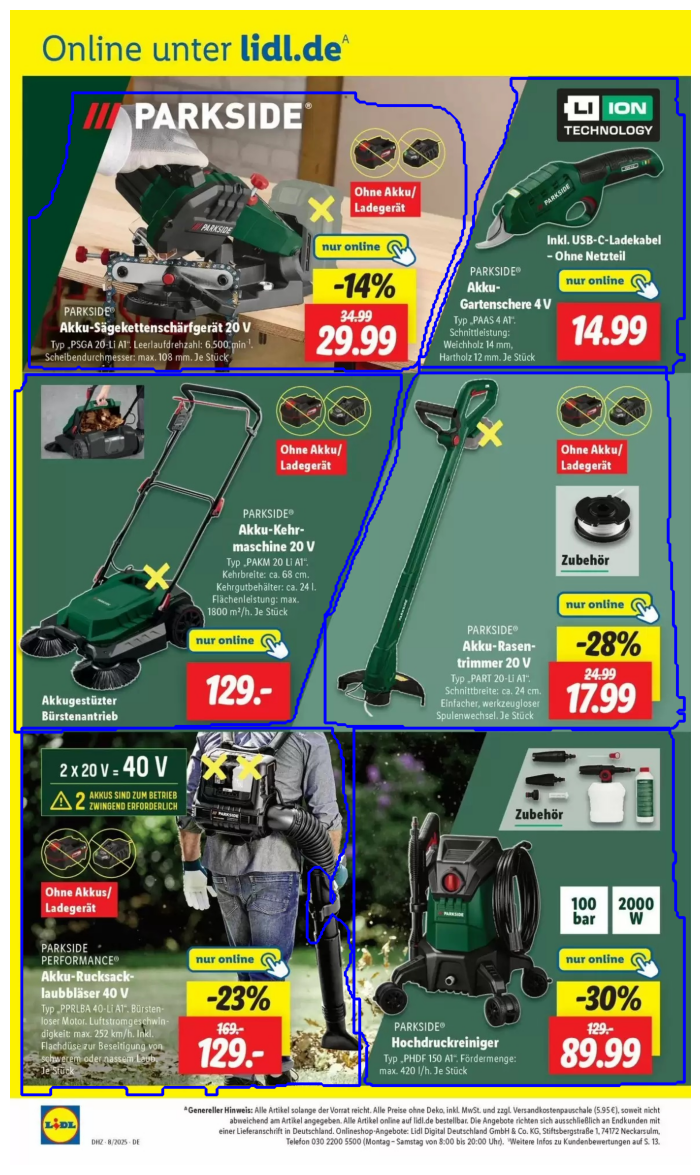

In [59]:
plt.figure(figsize=(25, 15))
plt.imshow(image_cv_mask)
plt.axis('off')
# plt.title('Bounding Boxes')
plt.show()
